In [81]:
import pandas as pd
import numpy as np
import os
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from tqdm.notebook import tqdm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import time
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from glob import glob
%matplotlib widget

# Paths

In [82]:
tables = '/arc/home/heestersnick/dwarforge/tables'
models = '/arc/home/heestersnick/dwarforge/models'
data_dir = '/arc/projects/unions/ssl/data/raw/tiles/dwarforge'
training_data_file = 'training_data_10x_rf.csv'
training_data = pd.read_csv(os.path.join(tables, training_data_file))

# Functions

In [83]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', cmap='viridis'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    gs = plt.GridSpec(len(labels), len(labels) + 1, width_ratios=[4] * len(labels) + [0.1])
    plt.figure(figsize=(len(labels) + 3, len(labels) + 3))
    ax = sns.heatmap(cm, annot=False, cmap=cmap, cbar_kws={"shrink": 0.805}, square=True, xticklabels=labels, yticklabels=labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            if (i == j):
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%", ha='center', va='center', fontsize=10, color='black')
            else:
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%", ha='center', va='center', fontsize=10, color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    #plt.savefig('/home/nick/Documents/Candidacy_Exam/Presentation/Figures/'+'cm_w_percentage.png', bbox_inches='tight', dpi=300)
    plt.show()

def classify_and_save_parquet(parent_folder, random_forest_model, features, df_path_out, band='cfis_lsb-r'):
    pattern = os.path.join(parent_folder, "*_*", band, "CFIS_LSB.*.r_rebin_det_params.parquet")
    positive_class_rows = []
    for file in tqdm(glob(pattern)):
        try:
            filename = os.path.basename(file)
            tile_numbers = filename.split('.')[1:3]
            tile_id = f"({tile_numbers[0]}, {tile_numbers[1]})"
            
            # Read the parquet file
            df = pd.read_parquet(file)

            # Select only the columns used for inference
            X = df[features]
            
            # Apply the random forest model
            df['class'] = random_forest_model.predict(X)

            # Aggregate rows where class = 1
            positive_rows = df[df['class'] == 1].copy()
            positive_rows['tile'] = tile_id  # Add file path for reference
            positive_class_rows.append(positive_rows)
            
            # Save the updated dataframe back to parquet
            df.to_parquet(file, index=False)
            
        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue
            
    # Combine all positive class rows into a single DataFrame
    if positive_class_rows:
        all_positive_rows = pd.concat(positive_class_rows, ignore_index=True)
        all_positive_rows.to_parquet(df_path_out, index=False)
    else:
        all_positive_rows = pd.DataFrame()
        
    return all_positive_rows

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Average Precision (AP) summarizes a precision-recall curve
    average_precision = average_precision_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    plot_confusion_matrix(y_test, y_pred, labels=['no dwarf','dwarf'])

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve: AP={average_precision:0.2f}')
    plt.show()

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.show()

def sample_and_shuffle_data(df, label_column='lsb', neg_pos_ratio=3, random_state=42):
    # Separate positive and negative examples
    positive_df = df[df[label_column] == 1]
    negative_df = df[df[label_column] == 0]

    # Calculate the number of negative examples to keep
    n_positive = len(positive_df)
    n_negative_to_keep = n_positive * neg_pos_ratio

    # Sample negative examples
    if len(negative_df) > n_negative_to_keep:
        negative_sample = negative_df.sample(n=int(n_negative_to_keep), random_state=random_state)
    else:
        negative_sample = negative_df  # Keep all if we don't have enough

    # Combine positive examples with sampled negative examples
    combined_df = pd.concat([positive_df, negative_sample])

    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return shuffled_df

# Random Forest

In [95]:
features = ['total_flux', 'mu_max', 'mu_median', 'mu_mean', 'n_pix', 're_arcsec', 'r_fwhm_arcsec', 'r_10_arcsec', 'r_90_arcsec', 'A_arcsec', 'B_arcsec', 'axis_ratio', 'mag', 'mu', 'lsb']
training_df = training_data[features]
training_df = sample_and_shuffle_data(training_df, neg_pos_ratio=10.)
X, y = training_df.drop(columns=['lsb']), training_df['lsb']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(45))
print(f'Using {len(training_df)} examples. {np.count_nonzero(y == 1)} positive and {np.count_nonzero(y==0)} negative ones.')
print(f'{len(X_train)} are used for training, {len(X_test)} for testing.')

Using 11363 examples. 1033 positive and 10330 negative ones.
9090 are used for training, 2273 for testing.


In [103]:
dwarfs = training_data[training_data['lsb']==1].reset_index(drop=True)

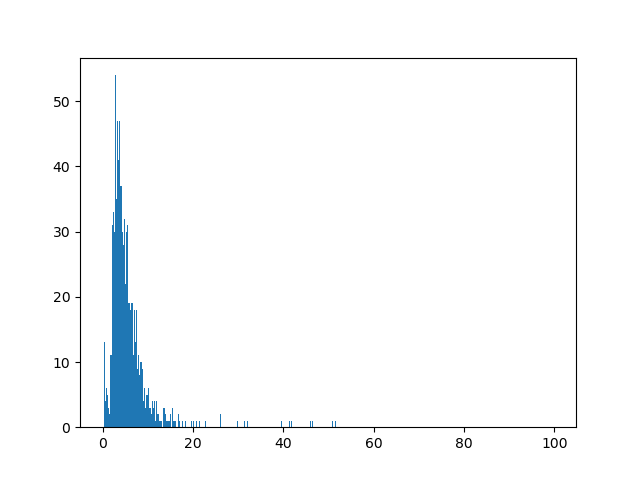

In [106]:
plt.figure()
plt.hist(dwarfs['re_arcsec'].values, bins=np.arange(0,100,0.2))
plt.show()

In [5]:
# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=np.random.randint(98))
# Train the classifier
start_time = time.time()
rf_classifier.fit(X_train, y_train)
print('Training done! Finished in {} minutes.'.format((time.time()-start_time)/60))
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

Training done! Finished in 0.09559887647628784 minutes.


# Evaluate the model

In [6]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9444444444444444
Precision: 0.9403669724770642
Recall: 0.9534883720930233
F1 Score: 0.9468822170900693


# Grid search for hyperparameters

In [100]:
class_weights = {0: 1, 1: 5}

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9, 12],
              'max_samples': [0.3, 0.5, 0.8],
             'class_weight': [class_weights, 'balanced', 'balanced_subsample', None]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15, cv=5, scoring='f1').fit(X_train, y_train)
model = model.best_estimator_

In [97]:
model

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       max_features=0.30000000000000004, max_samples=0.5,
                       n_estimators=65)

# Model evaluation

Accuracy: 0.9586
Precision: 0.7238
Recall (Sensitivity): 0.8607
Specificity: 0.9681
F1 Score: 0.7864
Balanced Accuracy: 0.9144
ROC AUC: 0.9766
Average Precision: 0.8491


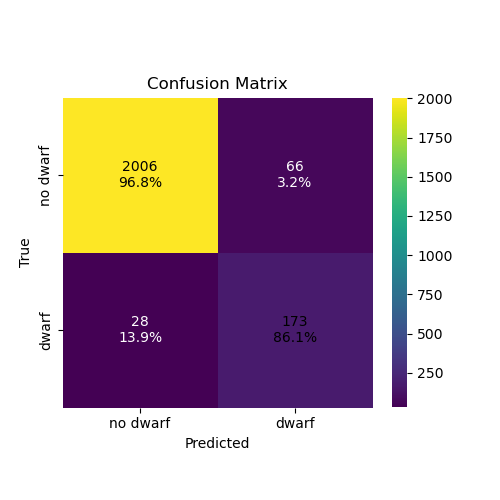

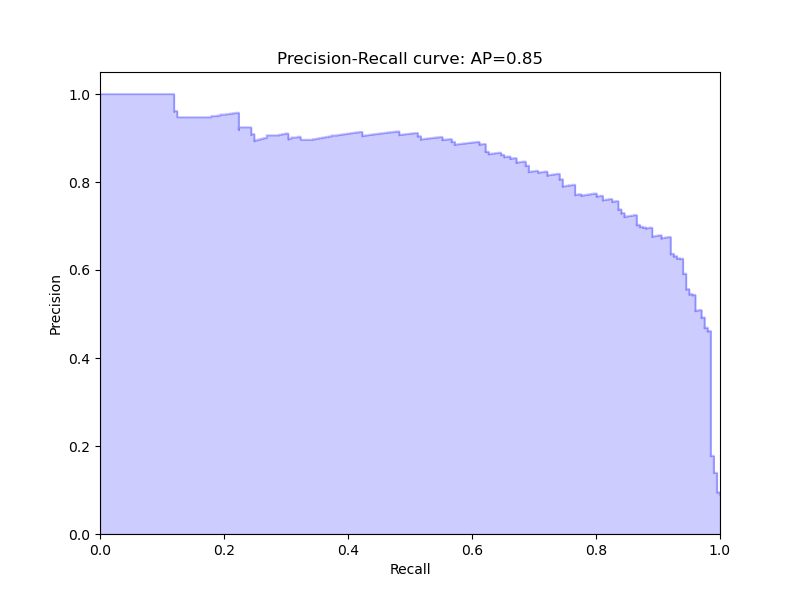

In [ ]:
evaluate_model(model, X_test, y_test)

# Feature importance

In [89]:
model.fit(X_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
feature_importance_df = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': (importances/np.sum(importances))})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df

,Feature,Importance
0,r_10_arcsec,0.262059
1,re_arcsec,0.223856
2,r_fwhm_arcsec,0.098452
3,r_90_arcsec,0.076730
4,B_arcsec,0.052965
5,mu,0.045953
6,mu_max,0.043626
7,A_arcsec,0.043139
8,mu_mean,0.032783
9,n_pix,0.027959


# Confusion matrix

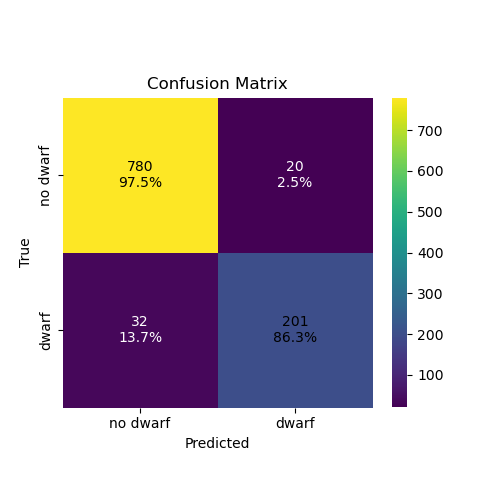

In [90]:
plt.close('all')
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels=['no dwarf','dwarf'])

# Save the Model

In [91]:
# Save the model to a file
joblib.dump(model, os.path.join(models, 'random_forest_model_4x_None.pkl'))

['/arc/home/heestersnick/dwarforge/models/random_forest_model_4x_None.pkl']

# Load the Model

In [17]:
loaded_model = joblib.load(os.path.join(models,'random_forest_model_1033.pkl'))

# Apply the Model to the Data

In [109]:
pos_class_df_path = os.path.join(tables, 'pos_class.parquet')
# classify_and_save_parquet(data_dir, loaded_model, features=features, df_path_out=pos_class_df_path, band='cfis_lsb-r')

In [110]:
pos_class = pd.read_parquet(pos_class_df_path)

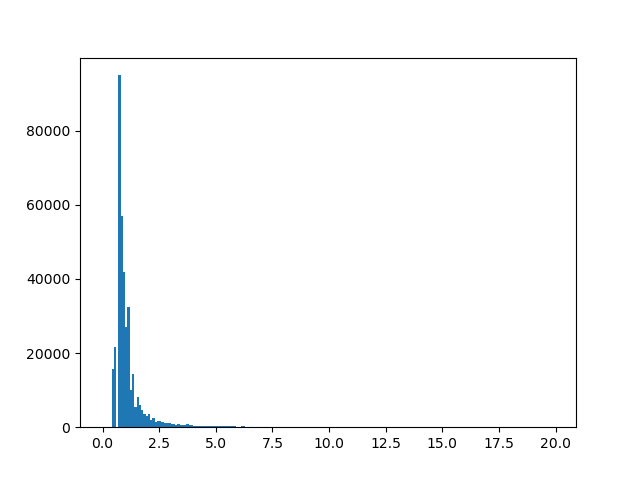

In [41]:
plt.figure()
bins = np.arange(0.001, 20, 0.1)
plt.hist(pos_class.r_10_arcsec.values, bins=bins)
plt.show()

In [42]:
dwarfs = training_data[training_data['lsb']==1].reset_index(drop=True)

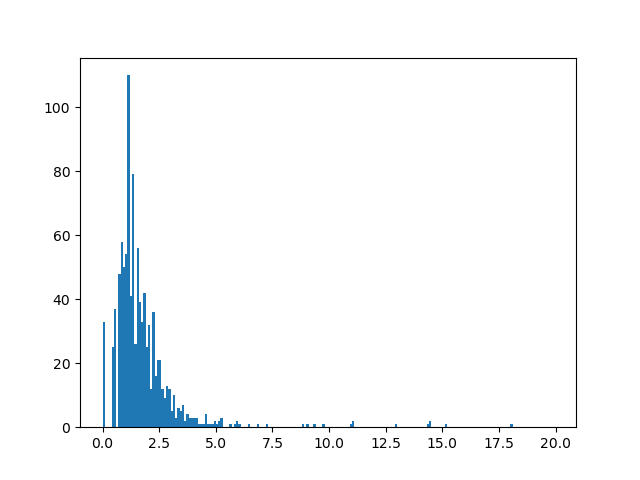

In [44]:
plt.figure()
bins = np.arange(0, 20, 0.1)
plt.hist(dwarfs.r_10_arcsec.values, bins=bins)
plt.show()

In [46]:
np.count_nonzero(dwarfs['r_10_arcsec'].values == 0.)

33

In [54]:
np.count_nonzero(dwarfs['r_10_arcsec'].values > 0.4)

1000

In [114]:
np.count_nonzero(pos_class['re_arcsec'].values <= 1.6)

961

In [107]:
pos_class

NameError: name 'pos_class' is not defined